# Pitfalls
When working with different Python libraries such as scikit-image and pyclesperanto, there are some special aspects / pitfalls to take care of. Some are hard to guess and this notebook serves highlighting some.

In [1]:
from skimage.io import imread
from skimage import filters
import pyclesperanto as cle
import stackview
import seaborn

## Intensity ranges
Some funtions such as [skimage.filters.gaussian]() normalize images, without telling the user. This leads to failing segmentation algorithms like demonstrated in this code snippet where the issue is not obvious:

c:\structure\code\stackview\stackview\_static_view.py:113: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)



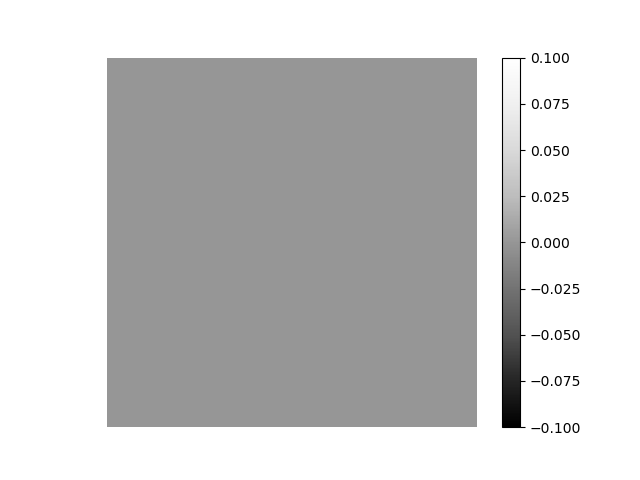
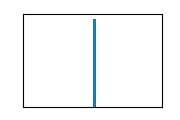

c:\structure\code\stackview\stackview\_static_view.py:113: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


shape (70, 70) 
 dtype bool 
 size 4.8 kB 
 min False max False
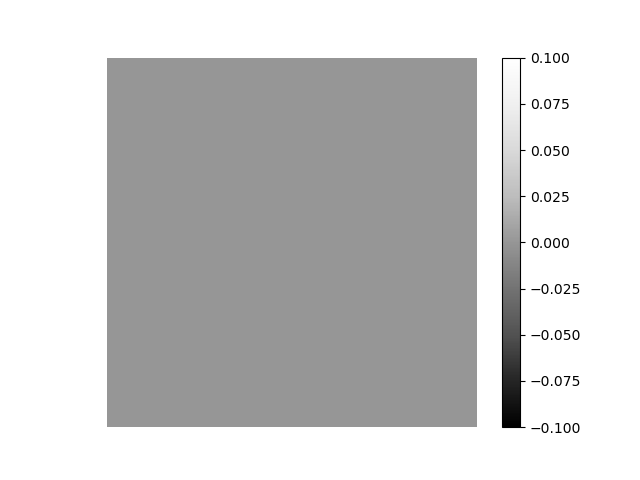
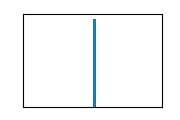

In [2]:
image = imread("data/mitosis_mod.tif")

# determine a threshold
threshold = filters.threshold_otsu(image)

# blur the image to make segmentation outlines smoother
blurred_image = filters.gaussian(image, sigma=2)

# threshold the image
binary_image = blurred_image > threshold

stackview.insight(binary_image)

The underlying issue is that the intensity range of `image` and `blurred_image` are different. The threshold determined on one image cannot be applied to the other image.

In [3]:
image.min(), image.max(), image.dtype

(8, 255, dtype('uint8'))

In [4]:
blurred_image.min(), blurred_image.max(), blurred_image.dtype

(0.06732543055888668, 0.7405626105467442, dtype('float64'))

One can fix the issue by modifying the code above in two ways:
* Apply `threshold_otsu` to the `blurred_image` instead of `image`.
* Add the parameter `preserve_range=True` to the `gaussian()` function.

## Return values
The threshold_otsu function in the `filters` module of scikit-image is not a filter. Instead of an image, it returns a number. This threshold needs to be applied to the image afterwards. In other libraries, this is not necessary.

In [5]:
image = imread("data/mitosis_mod.tif")

In [6]:
threshold = filters.threshold_otsu(image)

threshold

77

c:\structure\code\stackview\stackview\_static_view.py:113: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)



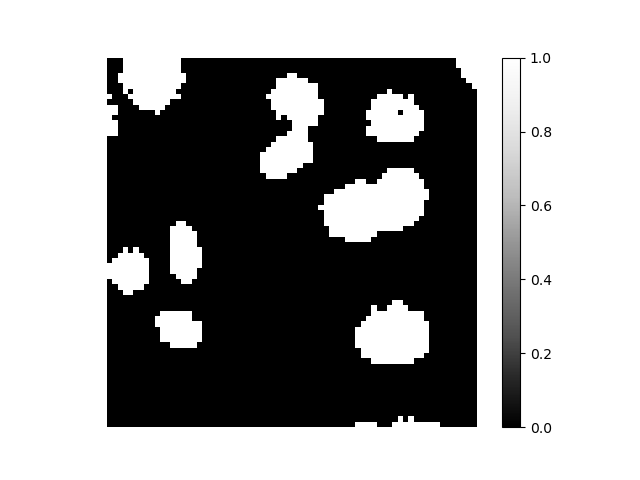
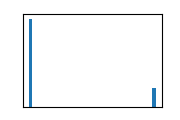

c:\structure\code\stackview\stackview\_static_view.py:113: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


shape (70, 70) 
 dtype bool 
 size 4.8 kB 
 min False max True
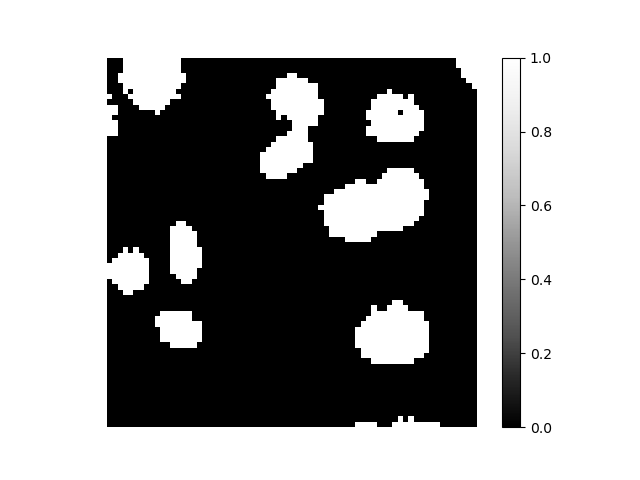
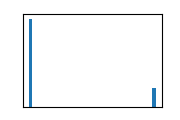

In [7]:
binary_image = image > threshold

stackview.insight(binary_image)

The `threshold_otsu` function in pyclesperanto returns the binary image directly.

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8, mtype=buffer)
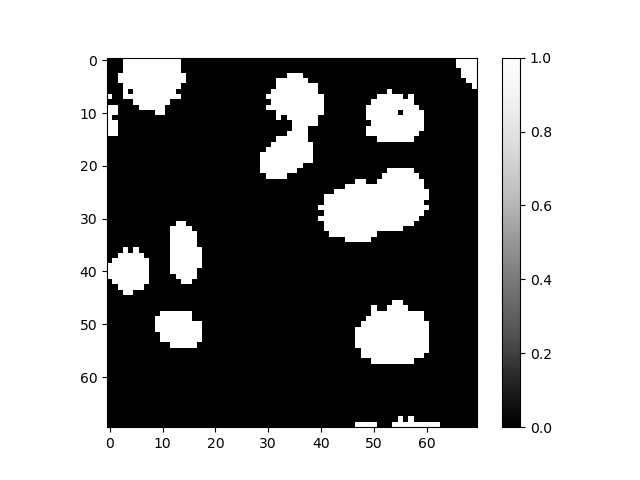
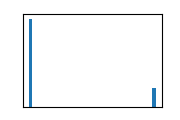

In [8]:
binary_image = cle.threshold_otsu(image)
binary_image

## GPU-drivers
In case there are error messages such as PLATFORM_NOT_FOUND or BUILD_PROGRAM_FAILURE, you may need to install [drivers for your graphics card](https://github.com/clEsperanto/pyclesperanto/?tab=readme-ov-file#troubleshooting-graphics-cards-drivers). You can debug what GPUs are detected with these commands: 

In [9]:
import pyclesperanto as cle

In [10]:
cle.available_device_names()

['NVIDIA GeForce RTX 4070 Laptop GPU', 'gfx1103']

In [11]:
cle.cl_info()

0 - (OpenCL) NVIDIA GeForce RTX 4070 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              560.94
	Device Type:                 GPU
	Compute Units:               36
	Global Memory Size:          8187 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         2046 MB
	Max Clock Frequency:         1230 MHz
	Image Support:               Yes
1 - (OpenCL) gfx1103 (OpenCL 2.0 AMD-APP (3617.0))
	Vendor:                      Advanced Micro Devices, Inc.
	Driver Version:              3617.0 (PAL,LC)
	Device Type:                 GPU
	Compute Units:               6
	Global Memory Size:          12302 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         10021 MB
	Max Clock Frequency:         800 MHz
	Image Support:               Yes

